# Coding assignment: shock tube 

Dans ce notebook nous allons aborder un exemple classique d'écoulement compressible à une dimension: le problème du tube à choc. Ce problème possède une solution analytique pour les équations d'Euler, ce qui permet de la comparer aux résultats numériques et d'évaluer leur précision. 


# Qu'est-ce qu'un tube à choc ? 

Un tube à choc est un dispositif idéalisé qui génère une onde de choc dans un gaz compressible. Le tube contient du gaz et est séparé en deux parties par une membrane extrêmement fine et rigide, la pression étant plus élevée dans une région que dans l'autre. Lorsque la membrane se rompt (on suppose que cela se fait de façon instantannée), une onde de choc est générée. 

# Position du problème

Nous allons partir des équations différentielles couplées suivantes (équations de conservation): 

\begin{equation}
\frac{\partial}{\partial t}
\left[ \begin{array}{c}
\rho \\
\rho u \\
\rho e_T \\ 
\end{array} \right]
+ \frac{\partial}{\partial x}
\left[ \begin{array}{c}
\rho u \\
\rho u^2 + p \\
(\rho e_T + p) u\\ \end{array}
\right]
=0
\end{equation}

où  $\rho$ est la densité du fluide, $u$ est la vitesse du fluide et $e_T = e + \frac{u^2}{2}$ est l'énergie spécifique totale.

Ces équations peuvent se réécrire sous forme vectorielle: 

\begin{equation}
\frac{\partial }{\partial t} \underline{\mathbf{u}} + \frac{\partial }{\partial x} \underline{\mathbf{f}} = 0
\end{equation}

avec

\begin{equation}\underline{\mathbf{u}} = \left[ \begin{array}{c}
\rho \\
\rho u \\
\rho e_T \\ 
\end{array} \right]\end{equation}

contenant les variables conservées et 



\begin{equation}\underline{\mathbf{f}} = \left[ \begin{array}{c}
\rho u \\
\rho u^2 + p \\
(\rho e_T + p) u \\ \end{array} \right]
\end{equation}

qui est le vecteur de flux. 


On considère un tube allant de $x=-10m$ à $x=10m$ et muni d'une membrane rigide en $x=0m$, les conditions initiales de densité, pression et vitesse du gaz respectivement à gauche et à droite de la membrane étant données par: 

$$\underline{IC}_L = \left[ \begin{array}{c}
\rho_L \\ u_L \\ p_L \\ \end{array}\right] = 
\left[ \begin{array}{c}
1\ kg/m^3 \\ 0\ m/s \\ 100\ kN/m^2 \\ \end{array}\right]$$

$$\underline{IC}_R = \left[ \begin{array}{c}
\rho_R \\ u_R \\ p_R \\ \end{array}\right] = 
\left[ \begin{array}{c}
0.125\ kg/m^3 \\ 0\ m/s \\ 10\ kN/m^2 \\ \end{array}\right]$$


La première s'applique pour $-10\leq x<0m$ et la seconde pour $0\leq x<10m$


Nous allons calculer la densité, la pression ainsi que la vitesse à $t=0.01s$ en utilisant la méthode de Richtmyer, donnée par: 



\begin{align}
\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} &= \frac{1}{2} \left( \underline{\mathbf{u}}^n_{i+1} + \underline{\mathbf{u}}^n_i \right) - 
\frac{\Delta t}{2 \Delta x} \left( \underline{\mathbf{f}}^n_{i+1} - \underline{\mathbf{f}}^n_i\right) \\
\underline{\mathbf{u}}^{n+1}_i &= \underline{\mathbf{u}}^n_i - \frac{\Delta t}{\Delta x} \left(\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} - \underline{\mathbf{f}}^{n+\frac{1}{2}}_{i-\frac{1}{2}} \right)
\end{align}

Notons que les vecteurs de flux utilisés dans la deuxième étape sont obtenus en calculant les fonctions de flux à l'issue de la première étape: 

$$\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} = \underline{\mathbf{f}}\left(\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}}\right).$$


# Résolution 

Commençons par importer tout ce dont nous allons avoir besoin pour la résolution ainsi que pour réaliser les graphiques et animations qui l'illustreront. 

In [2]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

On écrit deux fonctions, l'une pour calculer le flux, l'autre pour calculer l'énergie totale par unité de masse.

In [4]:
def computeF(g,u):
    r=u[1]**2/u[0]
    return numpy.array([u[1],
                       r+(g-1)*(u[2]-1/2*r),
                       (u[2]+(g-1)*(u[2]-1/2*r))*u[1]/u[0]])

In [5]:
def e(g,p,rho,v):
    return p/(g-1)/rho+1/2*v**2

On écrit ensuite une fonction qui implémente la méthode de Richtmyer:

In [6]:
def richtmyer(u_initial,g,dt,dx,tf):
    #un est un tableau à 3 indices: un premier pour désigner la variable (densité, flux, énergie spécifique), le deuxième pour 
    #désigner la position, le troisième pour désigner l'étape temporelle
    
    nt=int(tf/dt)+1
    
    un=numpy.zeros((3,nx,nt))
    un[:,:,0]=u_initial.copy()
    
    u=numpy.zeros((3,nx-1)) #contient les valeurs de u en i+1/2 et n+1/2 (pour une étape temporelle n
    #donnée) => a un premier indice pour la variable, un second pour donner la "demi-position": u[:,i] contient les variables
    #u_(i+1/2)
    for t in range(nt-1):
        F=computeF(g,un[:,:,t])
        u[:,:]=1/2*(un[:,1:,t]+un[:,:-1,t])-dt/dx/2*(F[:,1:]-F[:,:-1])
        f=computeF(g,u) #F en position i+1/2, temps n+1/2
        un[:,1:-1,t+1]=un[:,1:-1,t]-dt/dx*(f[:,1:]-f[:,:-1])
        un[:,0,t+1]=un[:,0,t]
        un[:,-1,t+1]=un[:,-1,t]
    return un

# Résultats

Nous avons à présent tout ce dont nous avons besoin pour évaluer les valeurs de vitesse, densité et pression au temps $t=0.01s$ et à $x=2.5m$. Il faut aussi fixer les conditions initiales.

In [9]:
dx=.25
dt=.0002
nx=81
g=1.4 #mis pour gamma

#Conditions initiales de vitesse, densité, pression et énergie totale par unité de masse.
#Les indices l et r correspondent aux conditions initiales respectivement à gauche et à droite de la membrane du tube.
u_initial=numpy.zeros((3,nx))
rho_il=1
v_il=0
p_il=100000
e_il=e(g,p_il,rho_il,v_il)
rho_ir=0.125
v_ir=0
p_ir=10000
e_ir=e(g,p_ir,rho_ir,v_ir)
u_initial[:,:40]=numpy.array([numpy.ones(40)*rho_il,
                             numpy.ones(40)*rho_il*v_il,
                             numpy.ones(40)*rho_il*e_il])
u_initial[:,40:]=numpy.array([numpy.ones(41)*rho_ir,
                             numpy.zeros(41)*rho_ir*v_ir,
                             numpy.ones(41)*rho_ir*e_ir])

Lançons la fonction résolvante:

In [10]:
r=richtmyer(u_initial,g,dt,dx,0.01)

L'évolution des trois variables du vecteur
\begin{equation}\underline{\mathbf{u}} = \left[ \begin{array}{c}
\rho \\
\rho u \\
\rho e_T \\ 
\end{array} \right]\end{equation}
se trouvent maintenant dans la variable $r$. La densité est accessible facilement. Pour avoir la vitesse à un instant et à une position données, il faut diviser la deuxième composante de $r$ à ces instant et positions par la première aux mêmes instant et positions. La pression peut se calculer depuis la formule donnée dans le notebook de l'énoncé:
$$p = (\gamma -1)\left(\rho e_T - \frac{\rho u^2}{2}\right)$$
qui se traduit en terme de r:
$$p=(\gamma - 1)(r[2]-\frac{r[1]^2}{2r[0]})$$
où toutes les composantes de $r$ sont prises aux mêmes positions et temps.
Les valeurs à la position $x=2.5m$ sont à la $50^{ème}$ composante, c'est-à-dire à l'indice $50$.

In [15]:
#vitesse
print(r[1,50,-1]/r[0,50,-1])
#densité
print(r[0,50,-1])
#pression
print((g-1)*(r[2,50,-1]-r[1,50,-1]**2/2/r[0,50,-1]))

292.611471527
0.374691402648
30250.8901676


Les valeurs affichées sont respectivement la vitesse, la densité et la pression à $x=2.5m$, à $t=0.01s$.

# Illustrations et conclusion 

Enfin, générons quelques animations pour les données de pression, densité et vitesse en fonction de la position afin d'avoir une vue d'ensemble du résultat:

In [16]:
xmin = -10
xmax = 10
x = numpy.linspace(xmin, xmax, nx)
nt=int(0.01/dt)+1 


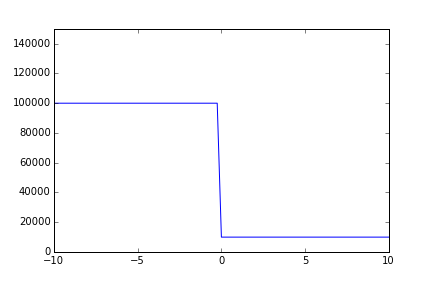
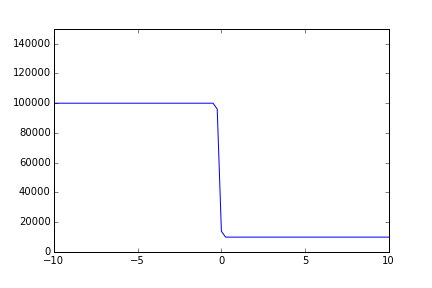
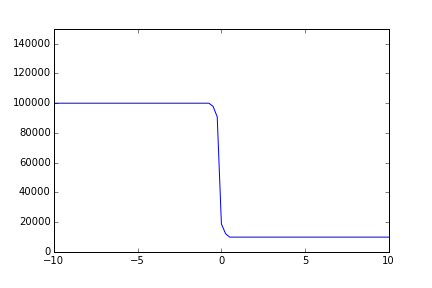
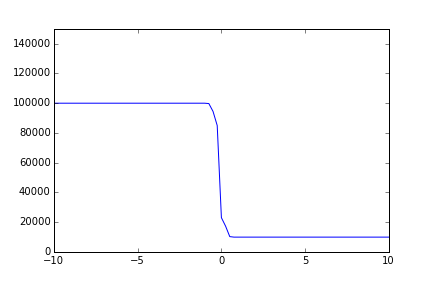
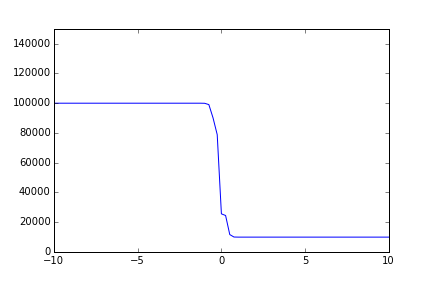
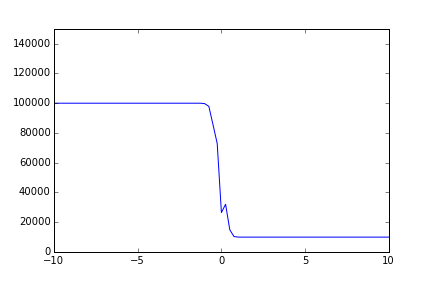
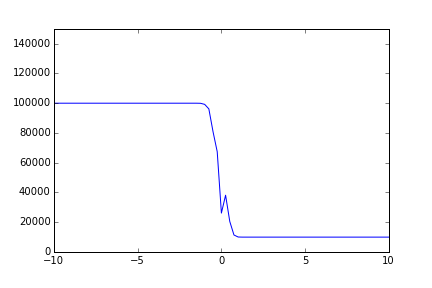
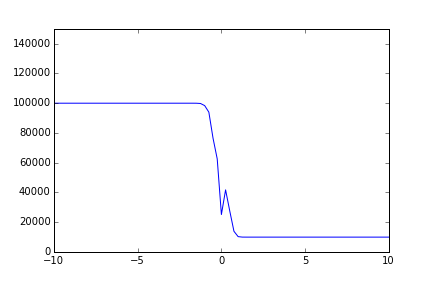
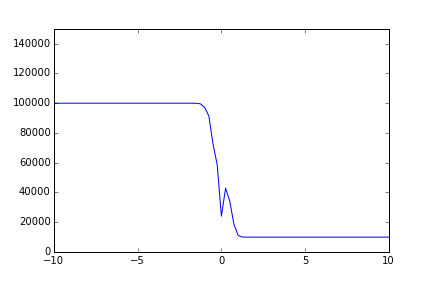
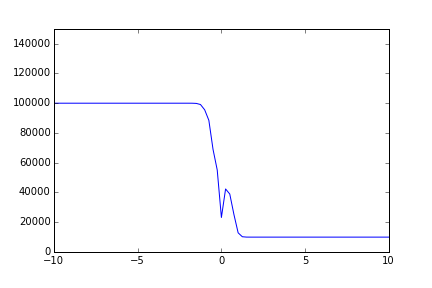
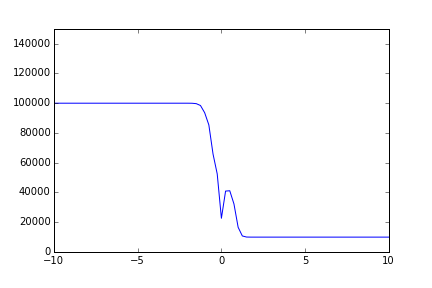
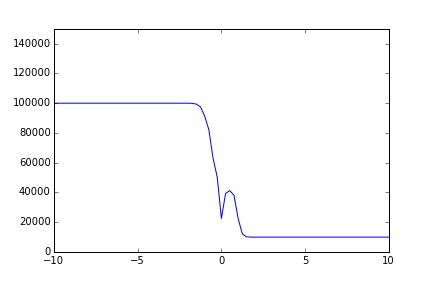
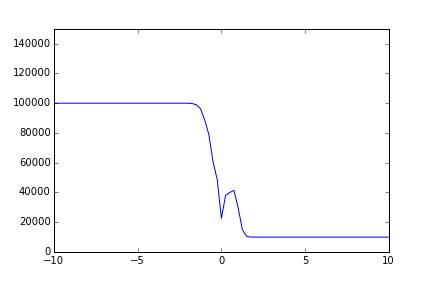
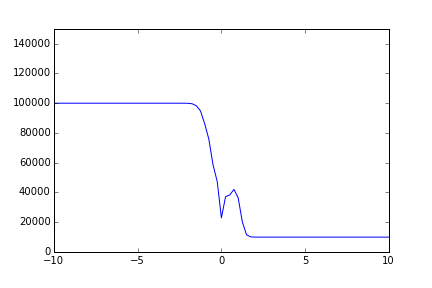
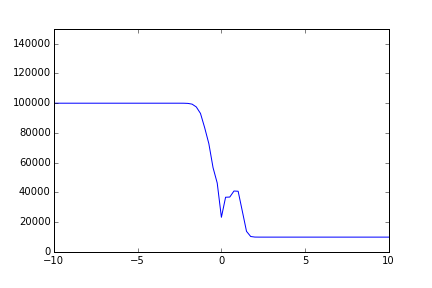
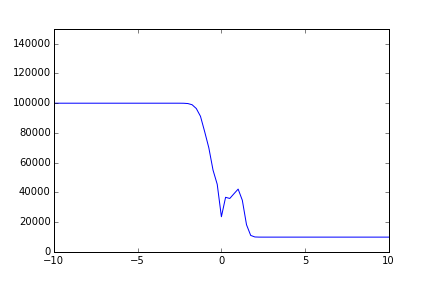
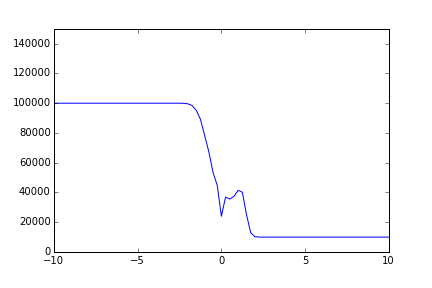
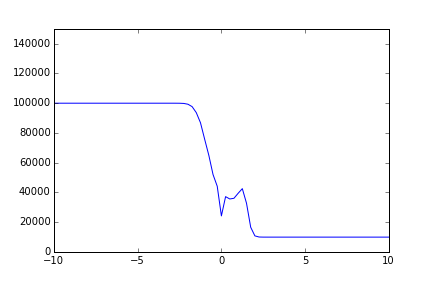
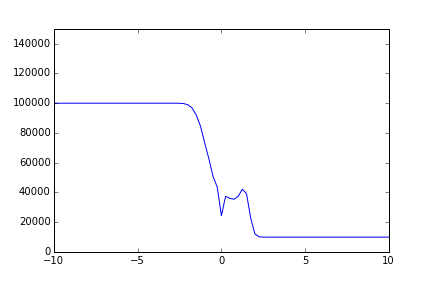
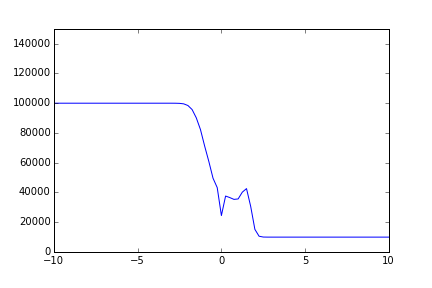
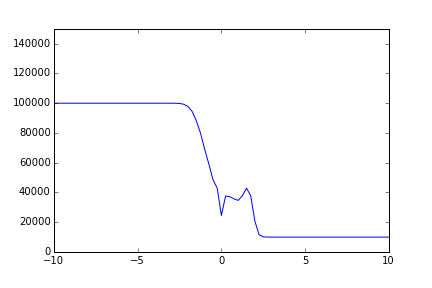
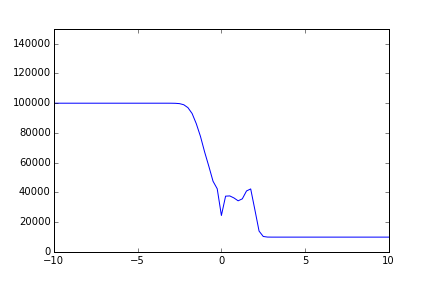
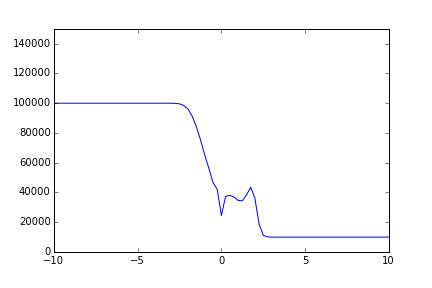
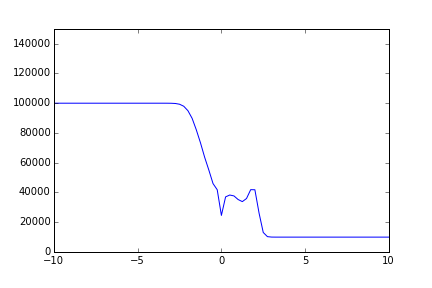
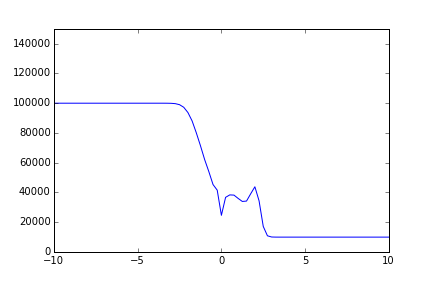
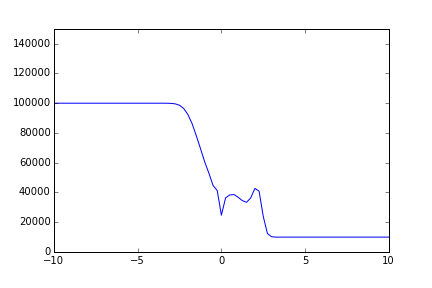
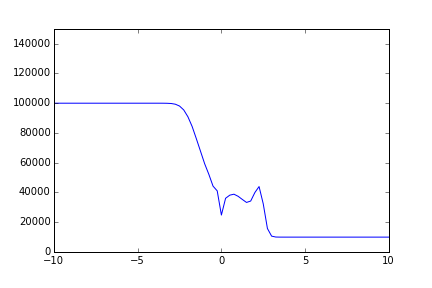
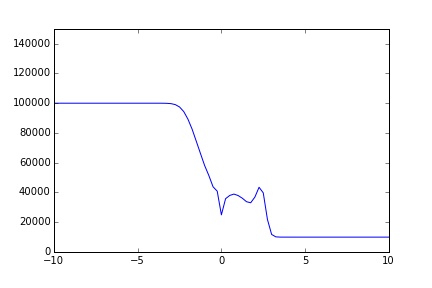
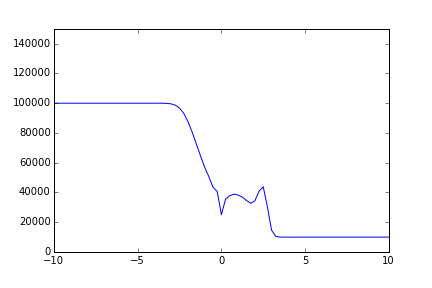
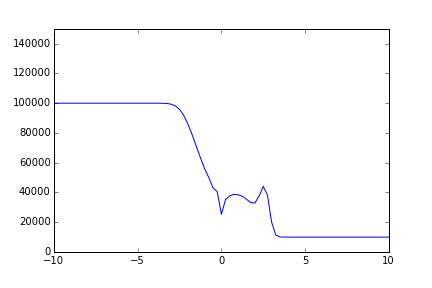
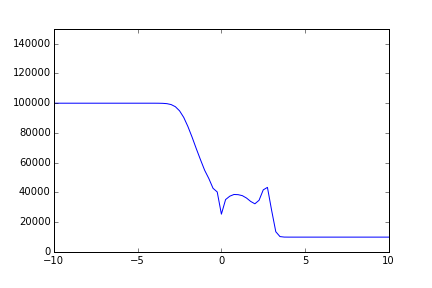
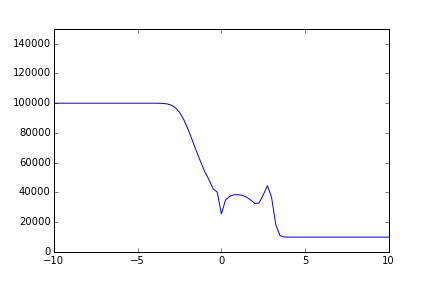
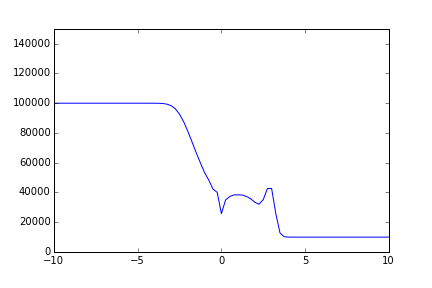
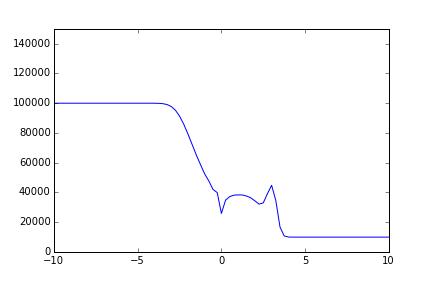
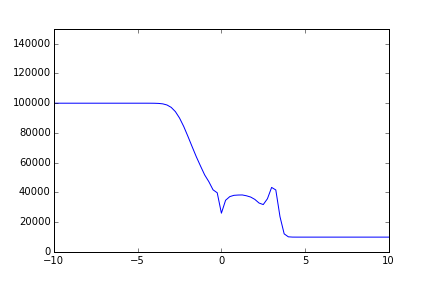
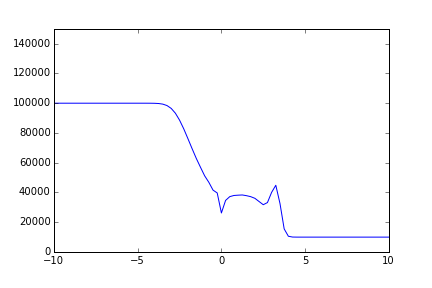
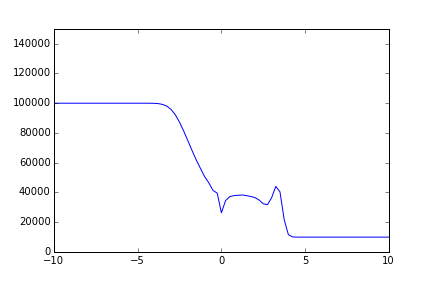
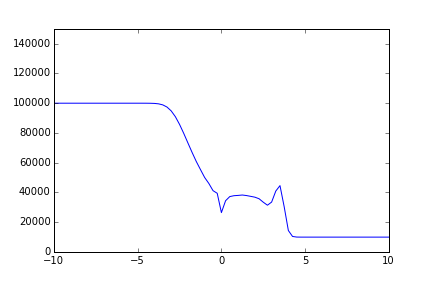
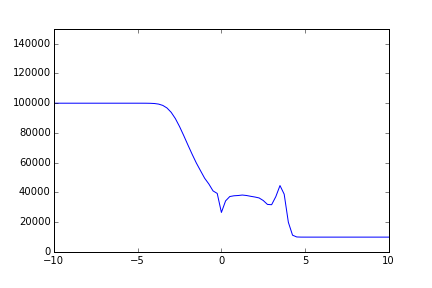
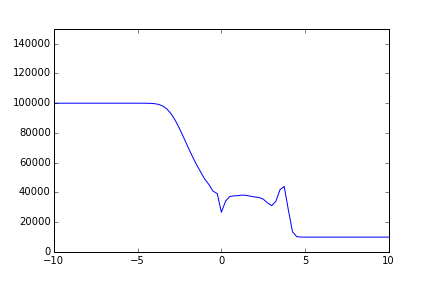
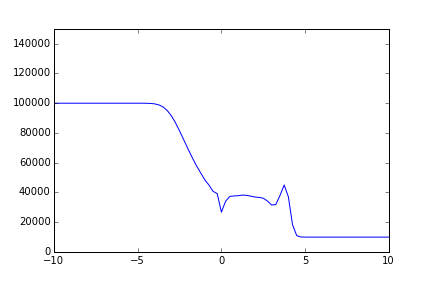
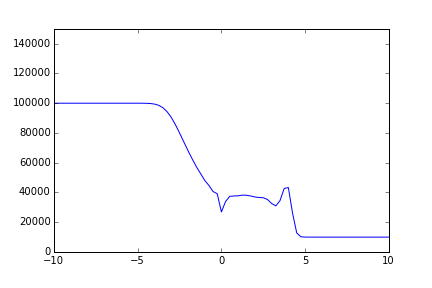
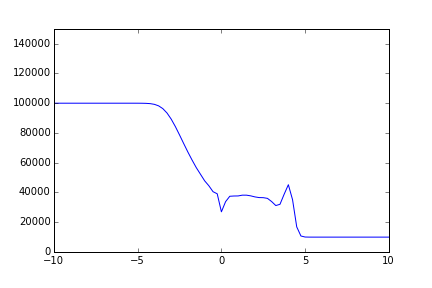
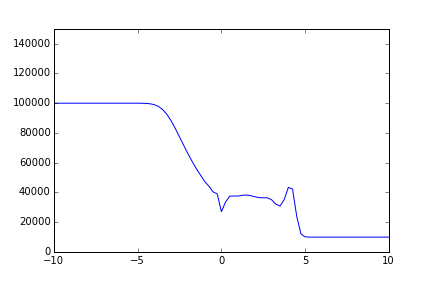
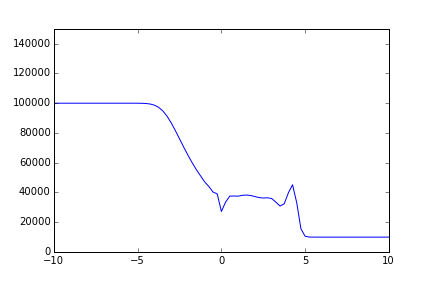
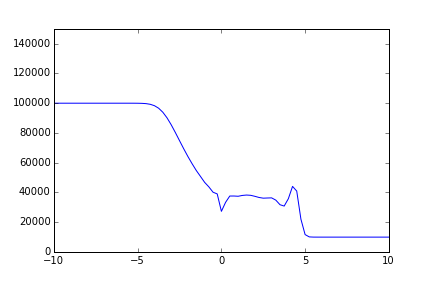
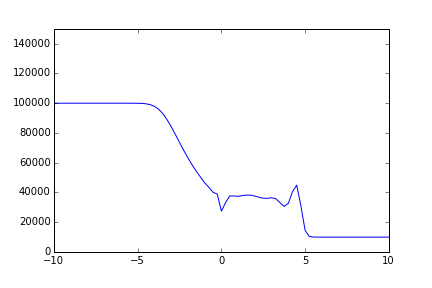
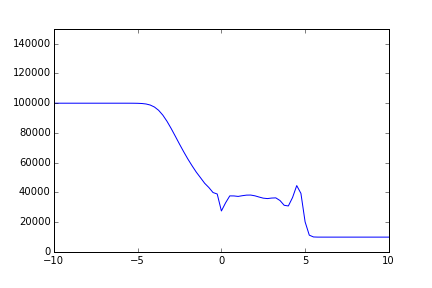
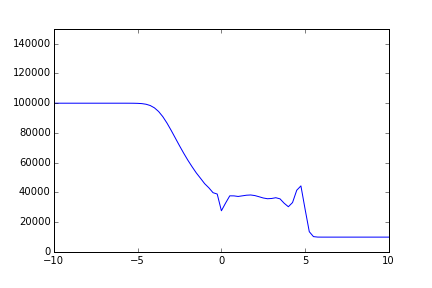
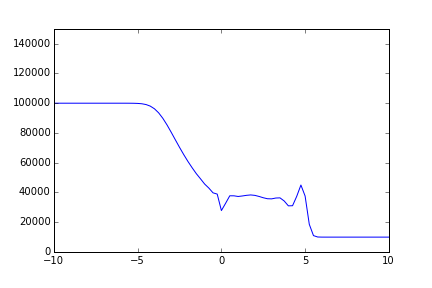

In [17]:
#Graphique de la pression

fig1 = pyplot.figure()
line1, = pyplot.plot([],[]) 
pyplot.xlim(xmin, xmax)
pyplot.ylim(0,150000)

def animate1(i):
    line1.set_data(x,0.4*(r[2,:,i]-r[0,:,i]*r[1,:,i]/2))
    return line1,
 
animation.FuncAnimation(fig1, animate1, frames=50, blit=True, interval=50, repeat=False)

On voit qu'après la rupture du diaphragme (correspondant à l'instant initial et à la position $x=0m$), la pression augmente dans la partie droite, et diminue dans la partie gauche (initialement à une pression plus haute que la partie droite), ce qui est bien ce que l'on s'attendait intuitivement à trouver étant donné le phénomène de diffusion du gaz. 


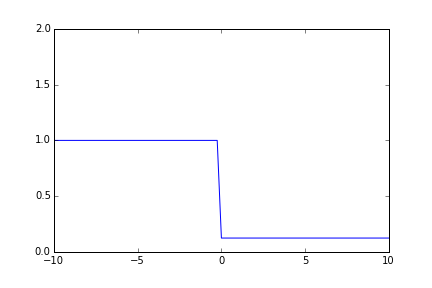
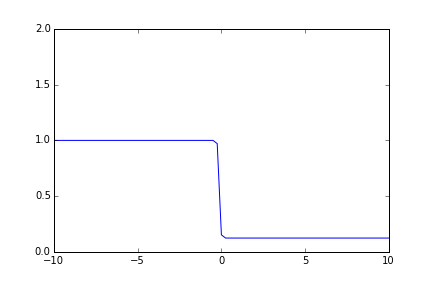
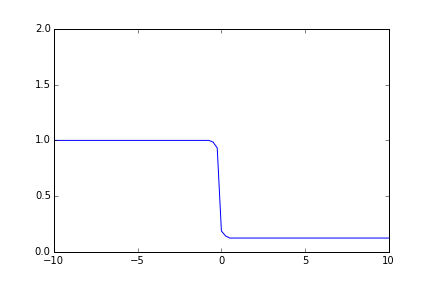
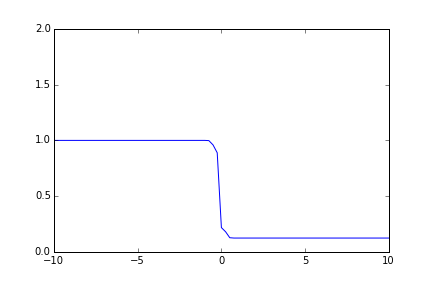
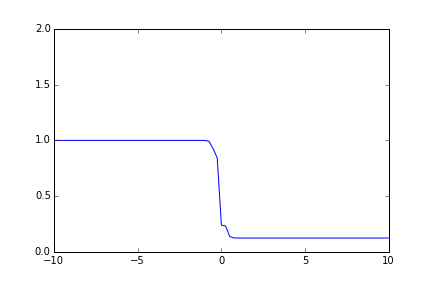
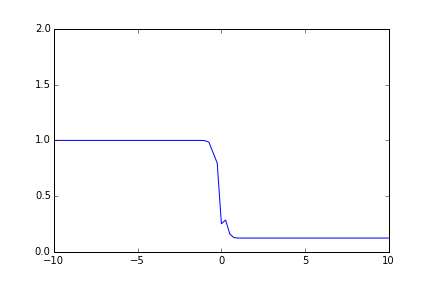
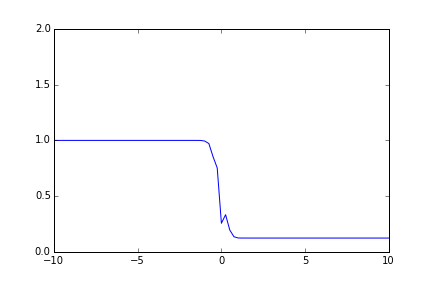
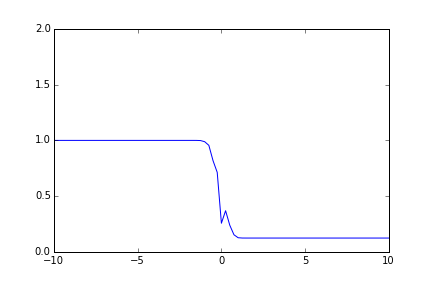
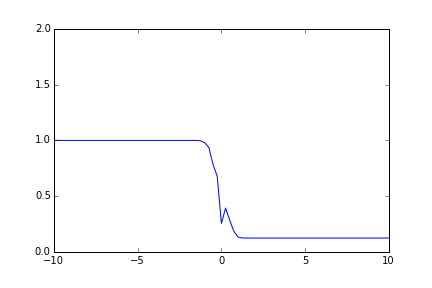
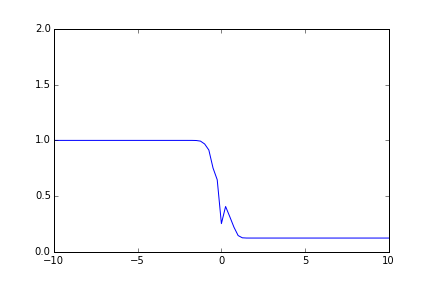
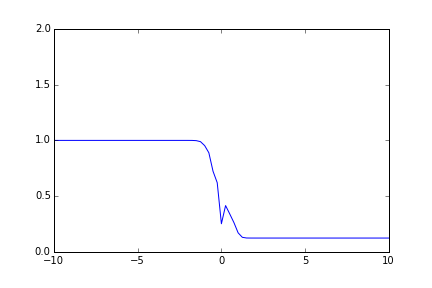
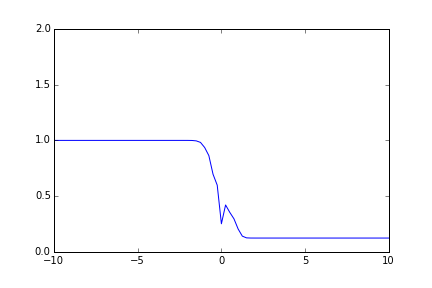
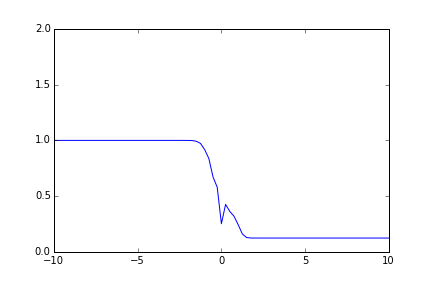
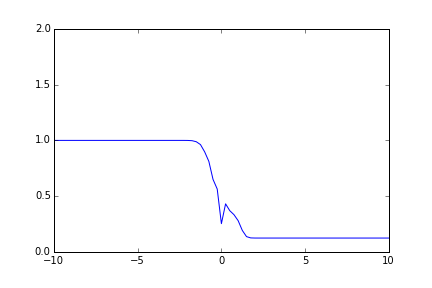
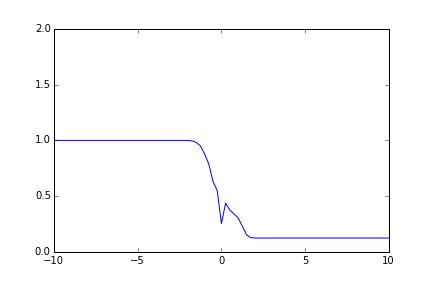
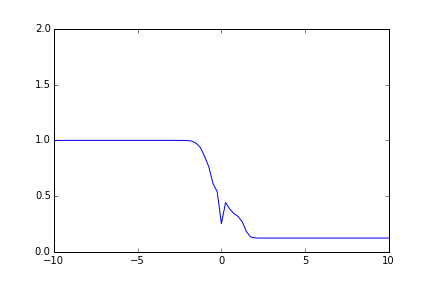
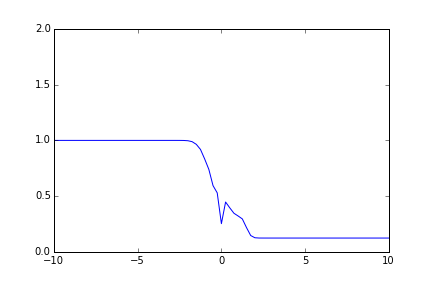
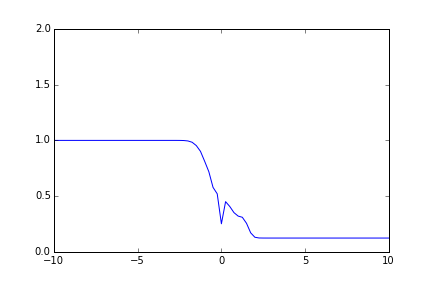
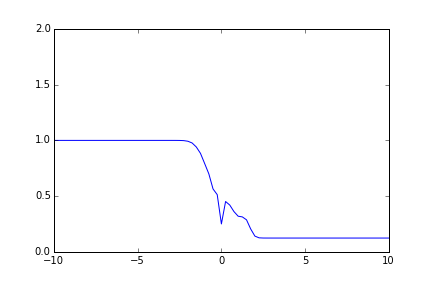
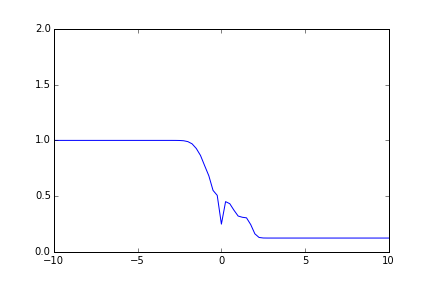
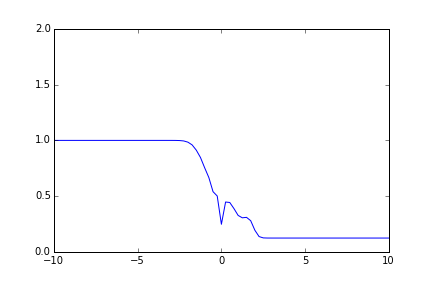
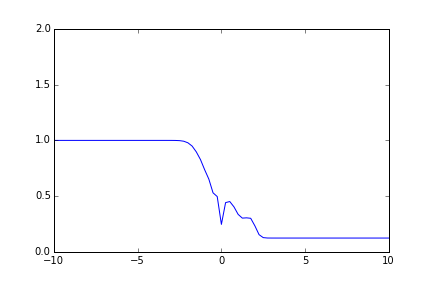
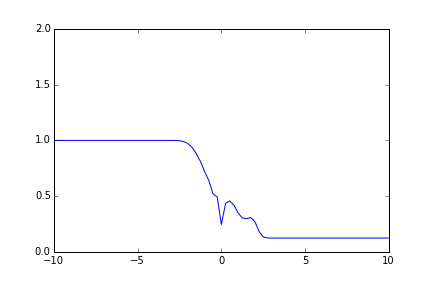
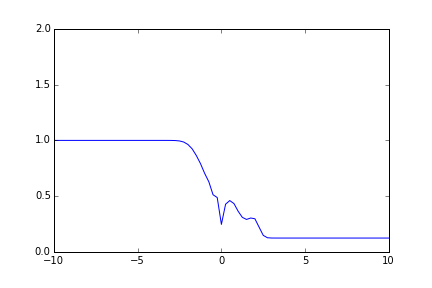
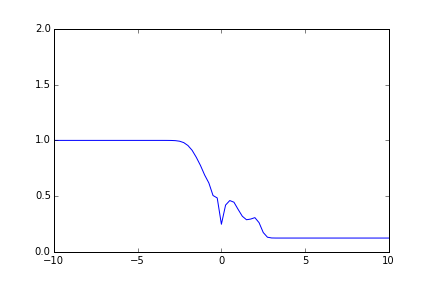
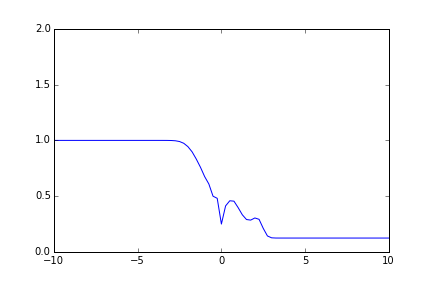
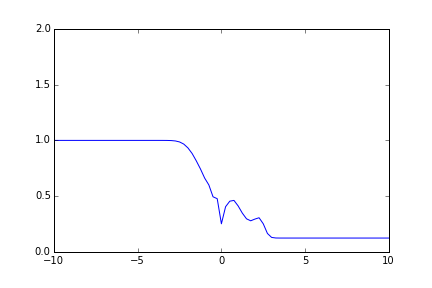
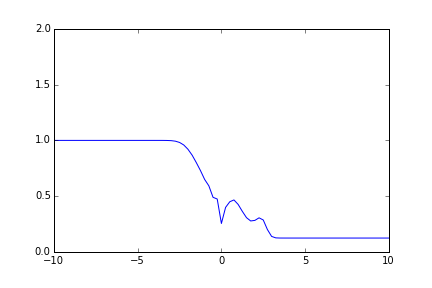
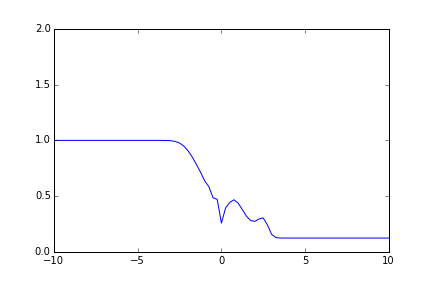
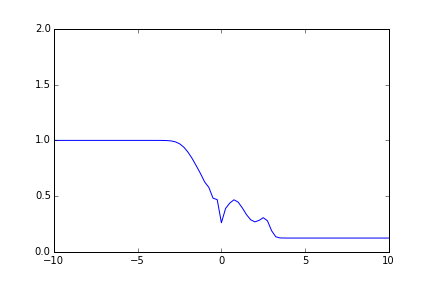
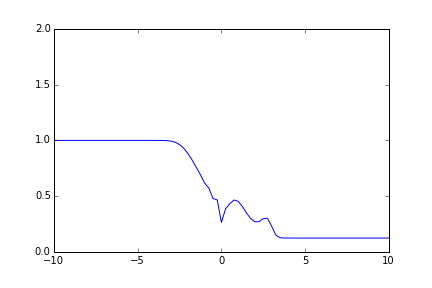
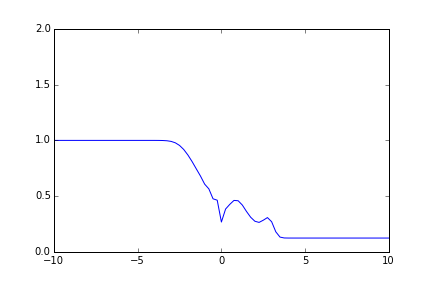
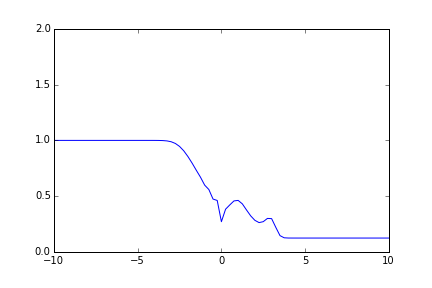
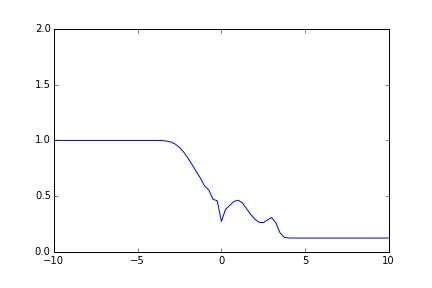
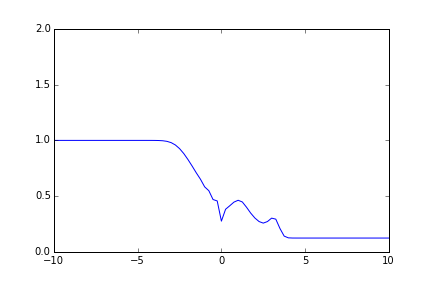
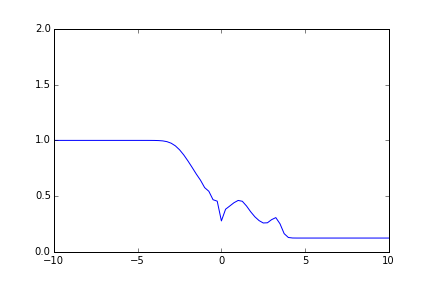
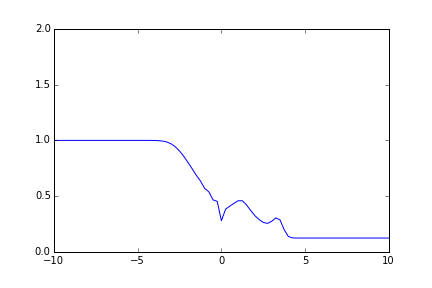
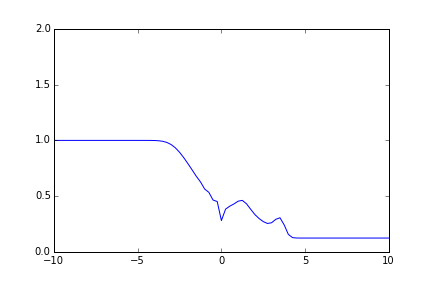
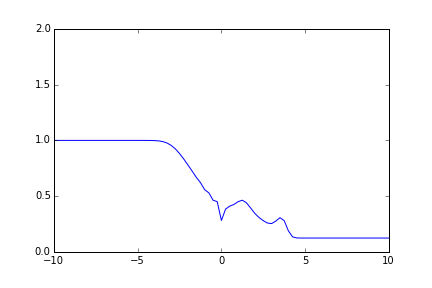
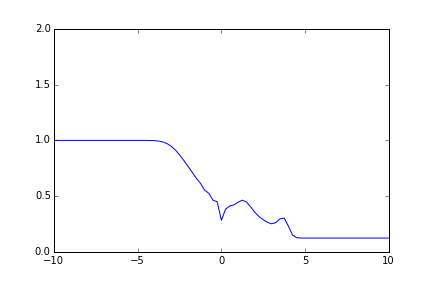
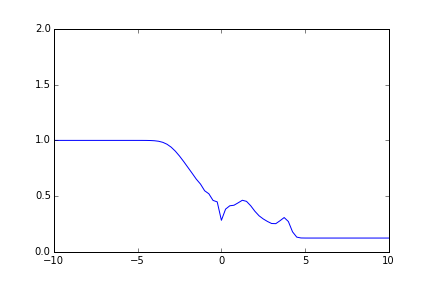
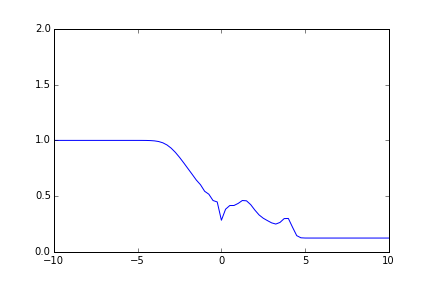
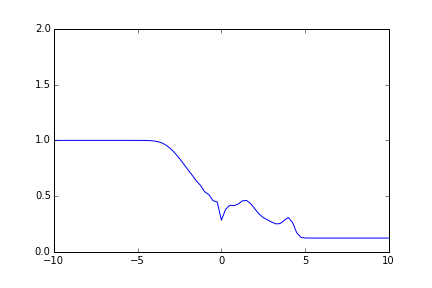
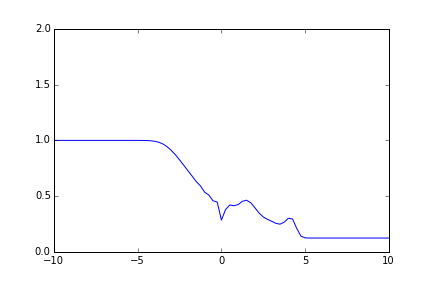
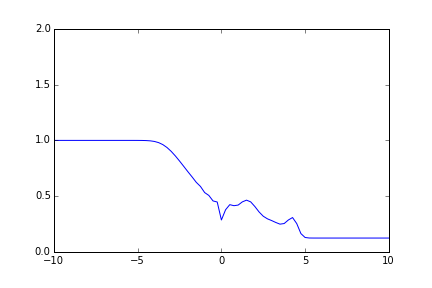
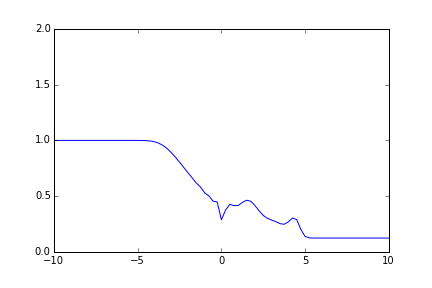
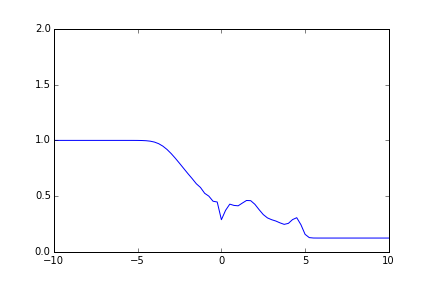
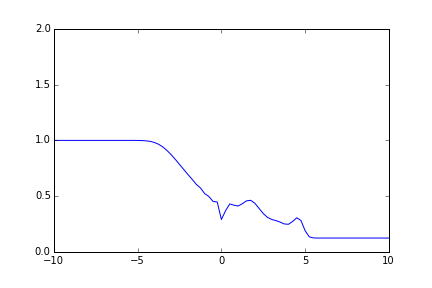
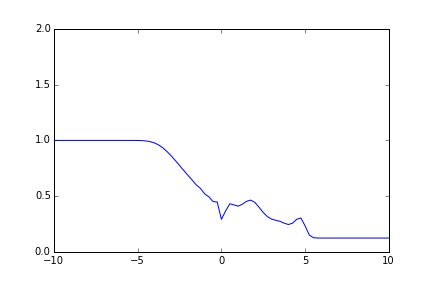
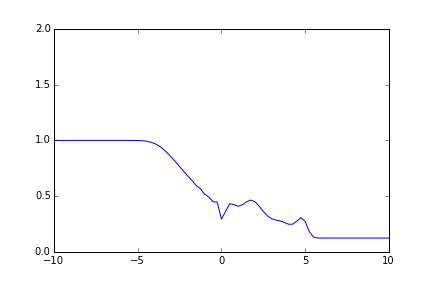

In [34]:
#Graphique de la densité

fig2 = pyplot.figure()
line2, = pyplot.plot([],[]) 
pyplot.xlim(xmin, xmax)
pyplot.ylim(0,2)

def animate2(i): 
    line2.set_data(x,r[0,:,i])
    return line2,
 
animation.FuncAnimation(fig2, animate2, frames=50, blit=True, interval=50, repeat=False)

La partie gauche du tube étant intialement à une densité plus élevé, le gaz se diffuse vers la partie droite après la rupture du diaphragme et la densité diminue donc à gauche et augmente à droite. 


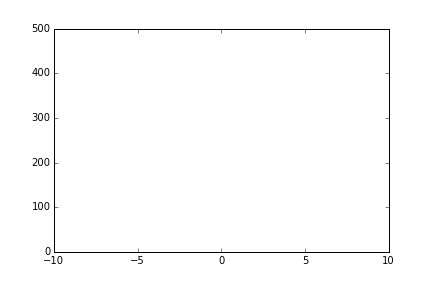
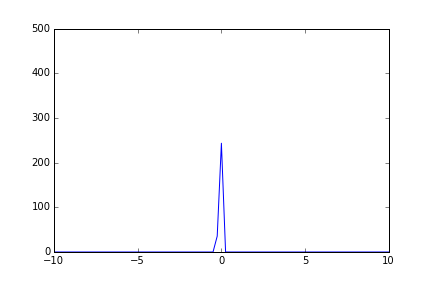
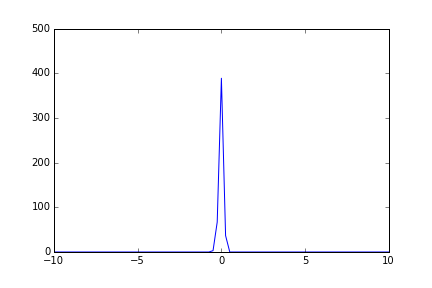
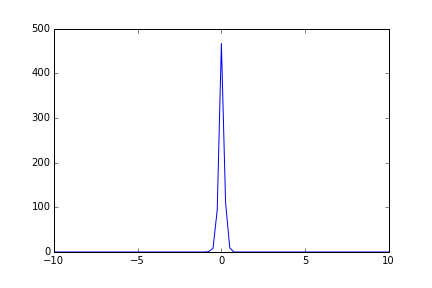
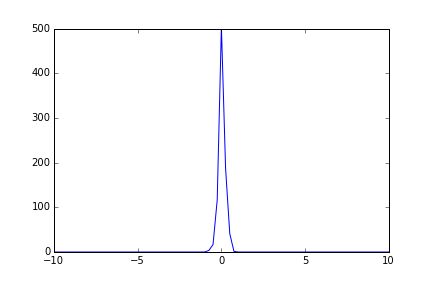
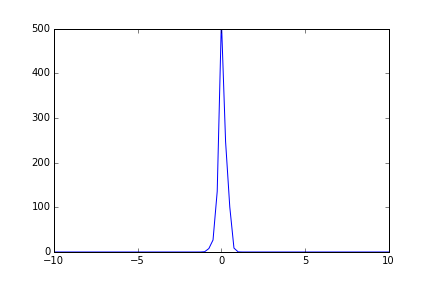
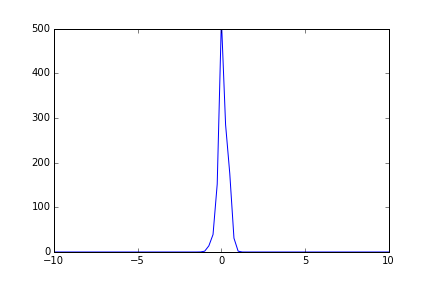
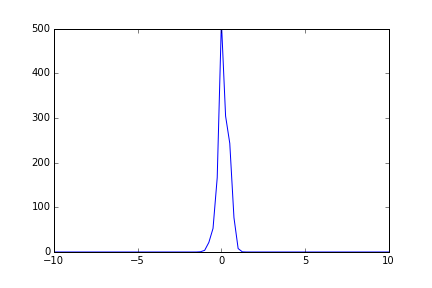
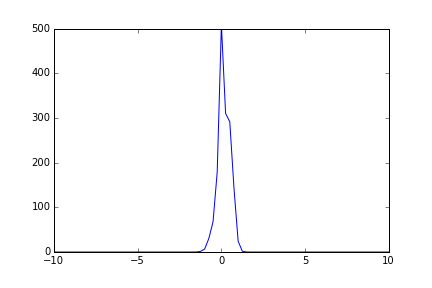
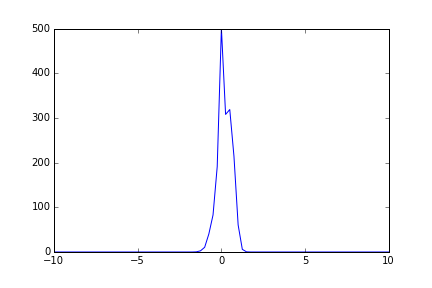
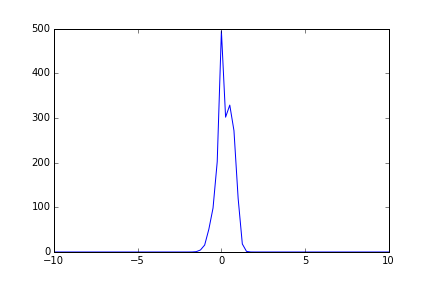
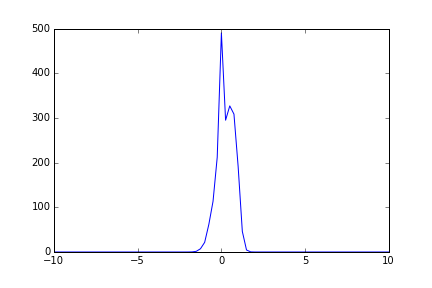
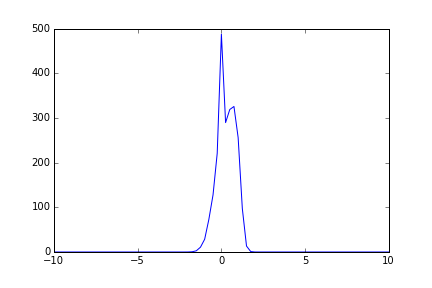
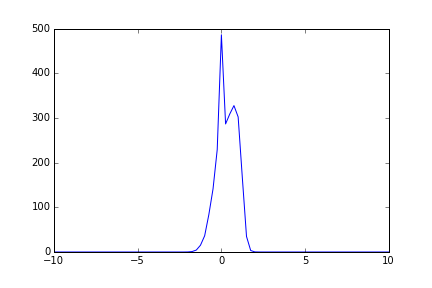
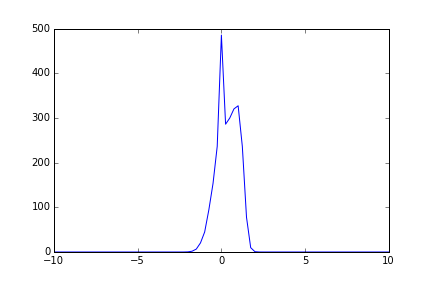
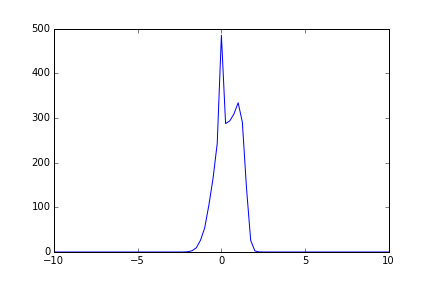
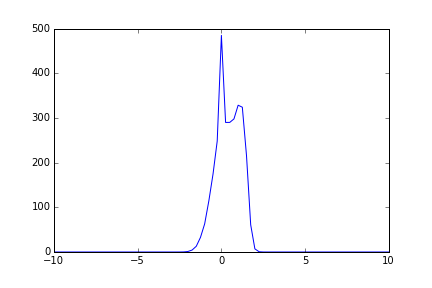
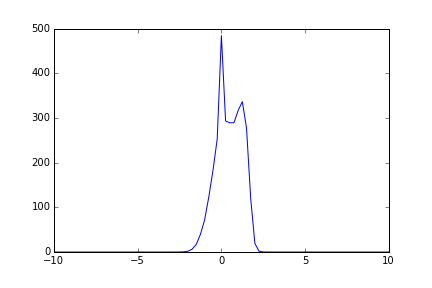
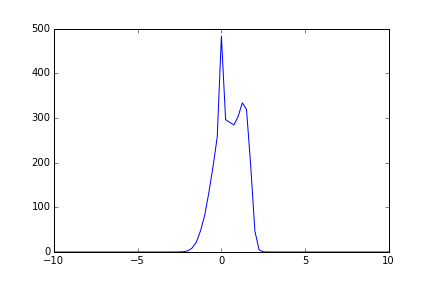
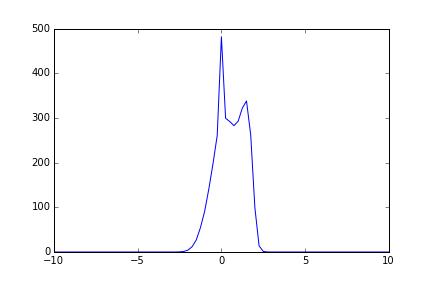
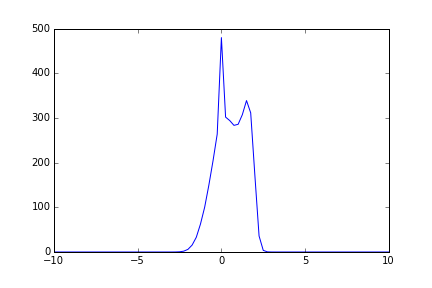
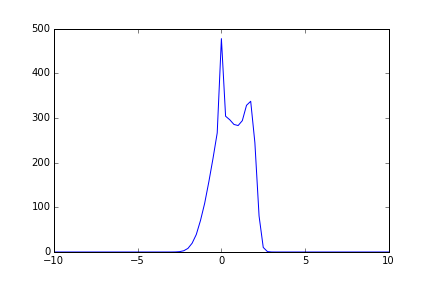
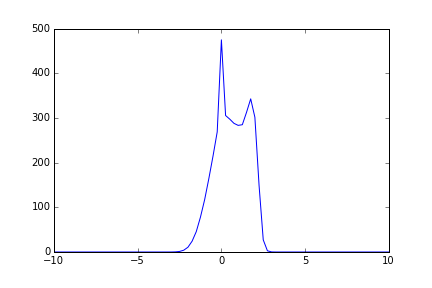
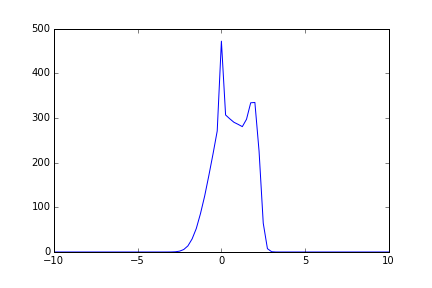
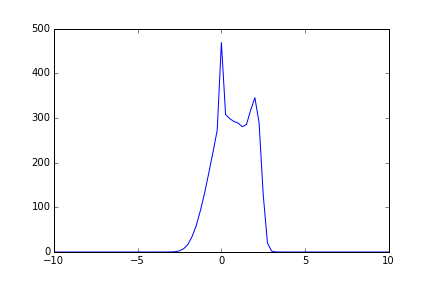
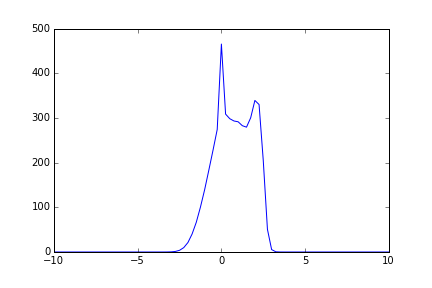
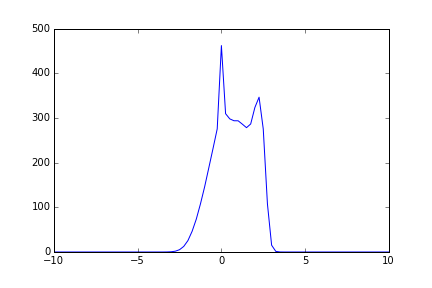
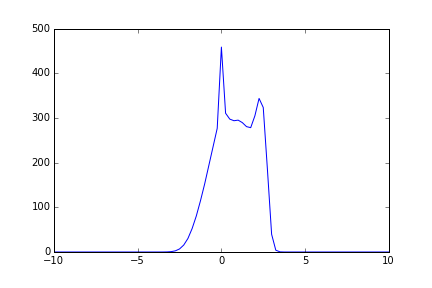
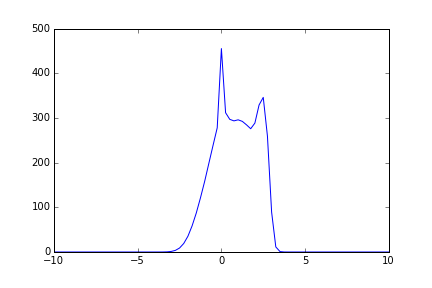
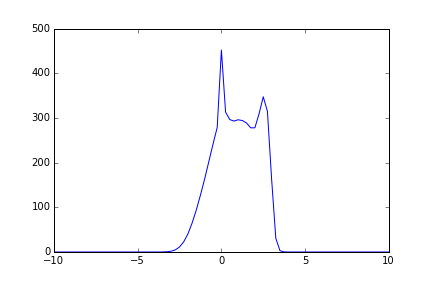
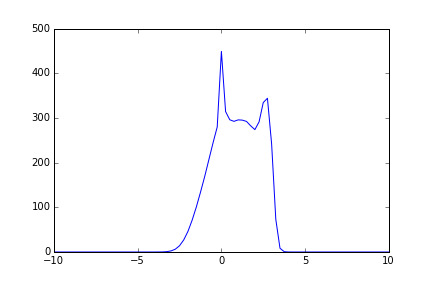
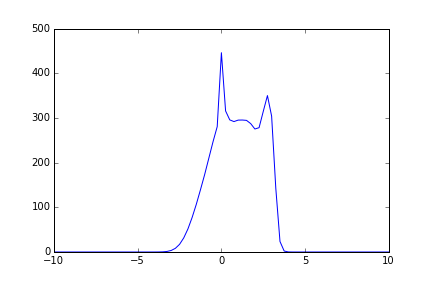
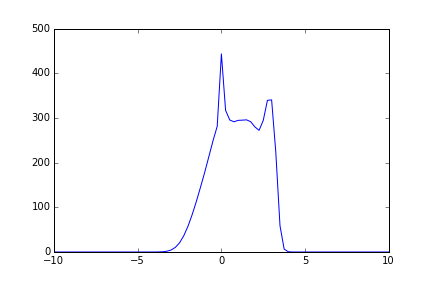
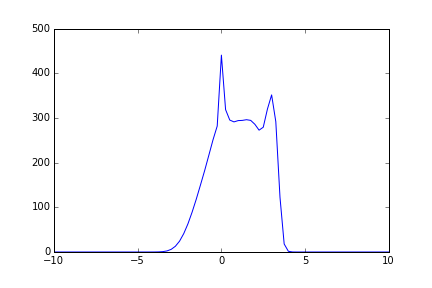
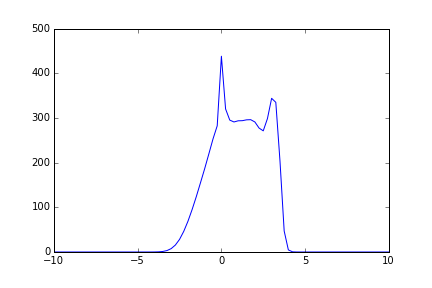
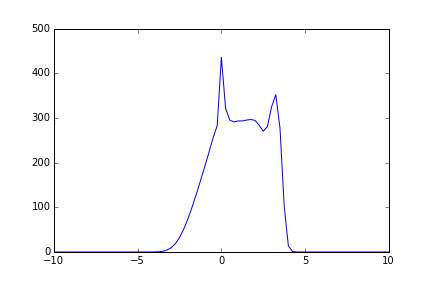
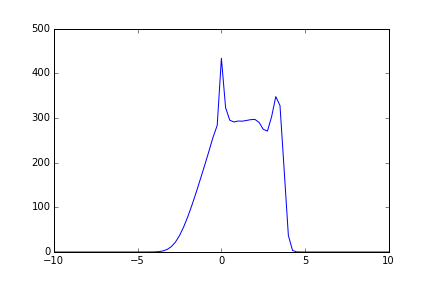
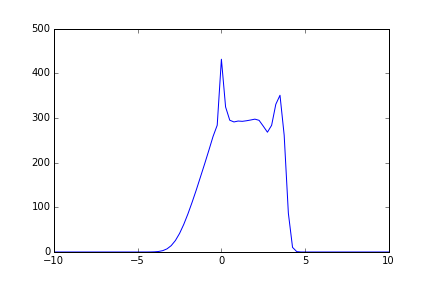
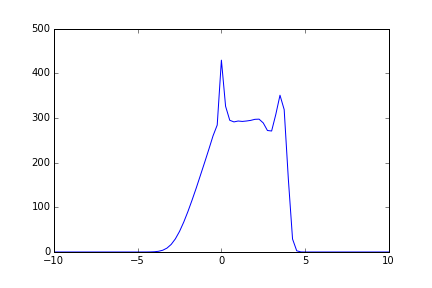
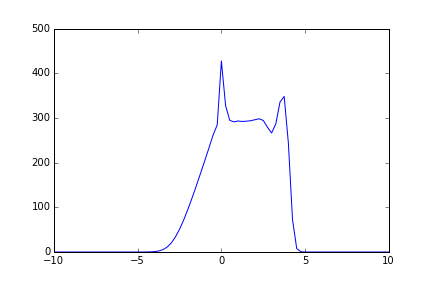
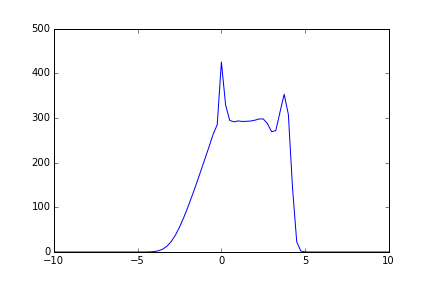
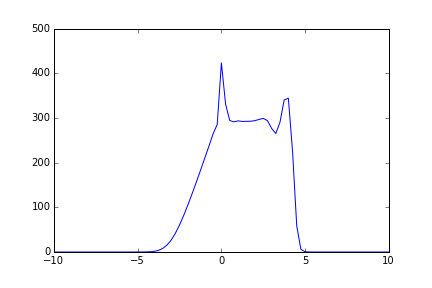
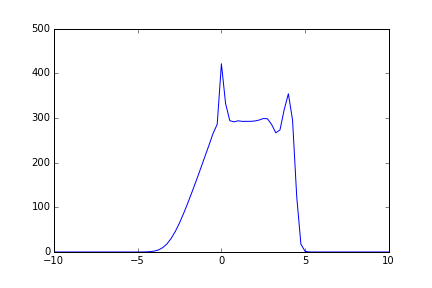
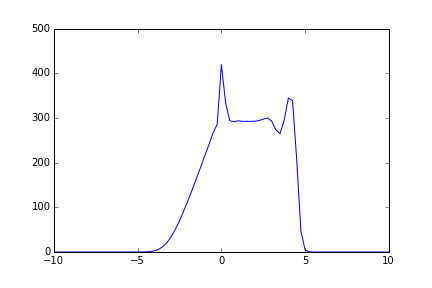
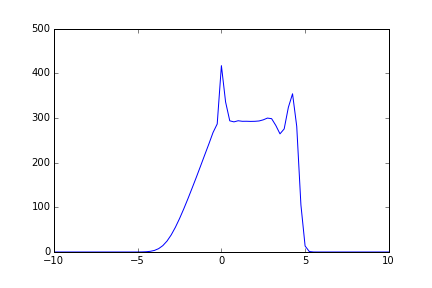
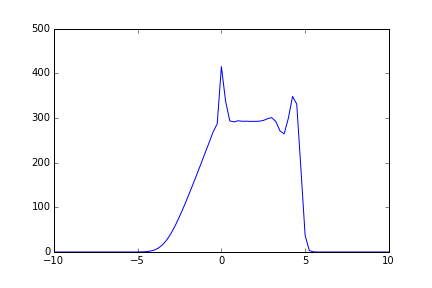
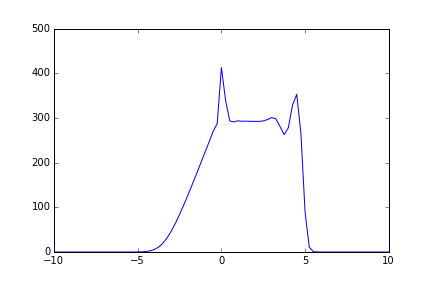
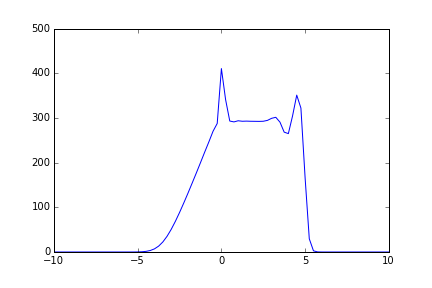
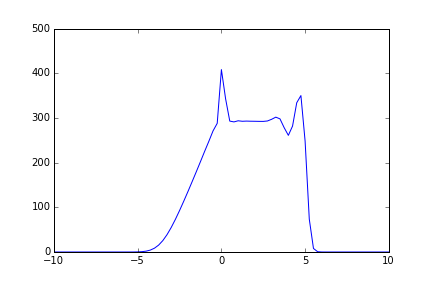
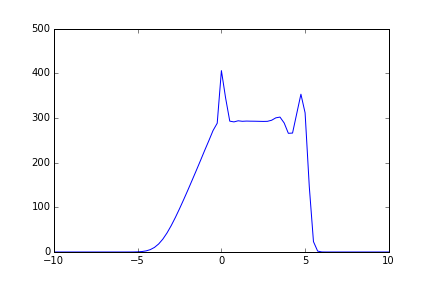

In [35]:
#Graphique de la vitesse

fig3 = pyplot.figure()
line3, = pyplot.plot([],[]) 
pyplot.xlim(xmin, xmax)
pyplot.ylim(0,500)

def animate3(i): 
    line3.set_data(x,r[1,:,i]/r[0,:,i])
    return line3,
 
animation.FuncAnimation(fig3, animate3, frames=50, blit=True, interval=50, repeat=False)

Le gaz étant initialement au repos dans les deux régions du tube, on a un pic de vitesse au moment de la rupture du diaphragme et on observe qu'elle augmente rapidement dans la partie droite du tube, ce qui s'explique par le fait que le gaz contenu intialement dans la région de pression plus haute se diffuse dans la partie initialement à une pression plus basse.

On remarque de plus dans les trois animations qu'il y a des oscillations induites par les discontinuités et les problèmes de dérivabilité, comme c'est souvent le cas. Une méthode traitant mieux ces discontinuités permettrait des résultats plus précis en ces points.